# Проект: классификация

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [161]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [163]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
pd.isnull(df['balance']).value_counts()[1]

25

### Задание 2

In [164]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

### Задание 3

In [165]:
df['balance'] = df['balance'].apply(lambda x: str(x).replace('$', ''))
df['balance'] = df['balance'] .apply(lambda x: str(x).replace(' ', ''))
df['balance'] = df['balance'] .apply(lambda x: float(str(x).replace(',00', '')))
df['balance'].mean()

1529.1290293615875

### Задание 4

In [166]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].mean()

1526.9360329690019

### Задание 5

In [167]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [168]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: str(df['job'].mode()[0]) if x == 'unknown' else str(x)) 
df['education'] = df['education'].apply(lambda x: str(df['education'].mode()[0]) if x == 'unknown' else x) 


In [169]:
df['education'].value_counts()

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [170]:
df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]['balance'].mean()

1598.8829787234042

### Задание 6

In [171]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    cleaned.reset_index(inplace=True)
    return outliers, cleaned

_,cleaned_df = outliers_iqr(df, 'balance')
cleaned_df.shape

(10105, 18)

## Часть 2:  Разведывательный анализ

### Задание 1

In [172]:
cleaned_df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

In [173]:

fig=px.pie(
    data_frame=cleaned_df['deposit'],
    names = 'deposit',
    title='Соотношение клиентов открывших и неоткрыших депозит',
    color = 'deposit',
    color_discrete_map={'Male':'blue','Female':'pink'},
    width=500,
    height=500
)
fig.show()


### Задания 2 и 3

In [174]:
cleaned_df = cleaned_df.drop(columns = "index")


In [175]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
cleaned_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [176]:

cleaned_df[cleaned_df['deposit'] == 'yes'].describe()

,age,balance,day,duration,campaign,pdays,previous
count,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000
mean,41.203162,953.071566,15.073489,539.568896,2.136296,68.776757,1.157018
std,13.291117,1040.543075,8.503427,394.408498,1.921040,119.854999,2.542359
min,18.000000,-1944.000000,1.000000,8.000000,1.000000,-1.000000,0.000000
25%,31.000000,163.000000,8.000000,245.000000,1.000000,-1.000000,0.000000
50%,38.000000,569.000000,15.000000,429.000000,2.000000,-1.000000,0.000000
75%,49.000000,1495.000000,21.000000,727.000000,2.000000,98.000000,1.000000
max,95.000000,4060.000000,31.000000,3881.000000,32.000000,854.000000,58.000000


In [177]:
cleaned_df[cleaned_df['deposit'] == 'no'].describe()

,age,balance,day,duration,campaign,pdays,previous
count,5424.000000,5424.00000,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000
mean,40.629978,682.15542,16.036320,221.316740,2.845870,36.253872,0.522124
std,10.196686,934.37434,8.362851,206.688801,3.199471,97.527835,1.901471
min,18.000000,-2049.00000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,33.000000,46.00000,8.000000,93.000000,1.000000,-1.000000,0.000000
50%,39.000000,342.00000,16.000000,163.000000,2.000000,-1.000000,0.000000
75%,48.000000,992.00000,22.000000,278.000000,3.000000,-1.000000,0.000000
max,89.000000,4063.00000,31.000000,3284.000000,43.000000,826.000000,41.000000


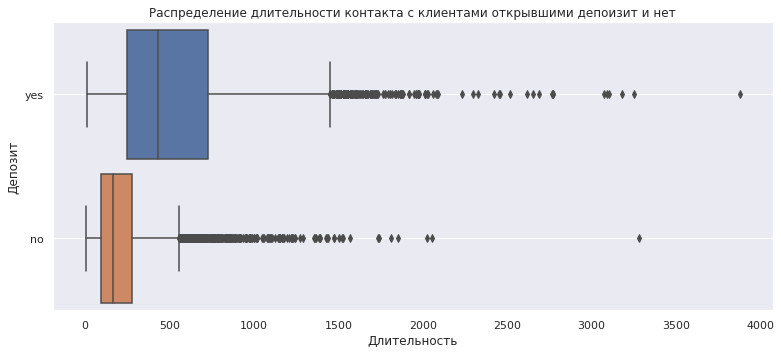

In [178]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='duration',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение длительности контакта с клиентами открывшими депоизит и нет');
boxplot.set_xlabel('Длительность');
boxplot.set_ylabel('Депозит');
boxplot.grid()

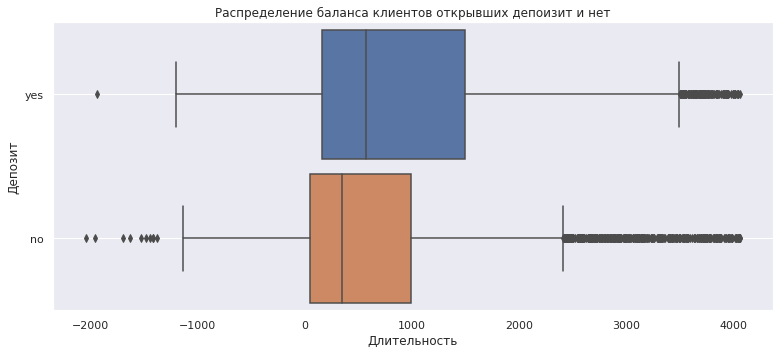

In [179]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='balance',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение баланса клиентов открывших депоизит и нет');
boxplot.set_xlabel('Длительность');
boxplot.set_ylabel('Депозит');
boxplot.grid()

### Итерпритация описательных статистик колличественных переменных.
##### Были получены статистики для колличественных переменных всего набора данных, а также отдельно для открывших депозит и нет. 
##### Про признак возраста на первый взгяд сказать нечего. Средний возраст практически не отличается для групп и всего набора данных, неадекватных выбрасов не наблюдается, максимальный возраст 95 лет хоть и является очень высоким, но теортически аномальным не является. В дальнейшем можно будет отнести большой возраст к бывросам по методу трех сигм. Признак day необходимо преобразовать в дату. Duration признак длительности контакта. Видна значительная разница в длительнсти контакта банка с клиентами открывшими депозит и нет. На ящиках с усами эта разница наглядно представлена, так же видны выбросы. По признаку колличества контакотов можно предположить, что с увеличением значения признака вероятность открытия депозита падает. Признак кооличества пропущенных дней с момента последней маркетинговой компании на данный момент ни о чем не говорит, так как имеет очень большое стандартное отклонение, сделать какие то выводы невозможно. По колличеству контактов до текущей компании видно, что люди имвешие хотя бы один контакт с банком ранее охотнее открывают депозит. По текущему балансу видно, что люди с большим колличеством денег охотнее не много открывают депозит, распределение визаулизировано.

### Задания 4 и 5

####  По полученной визуализации видно, что за исключением голубых воротничков, которые чаще отказываются от открытия депозита, в остальном вероятность открытия не зависит от работы. 

In [180]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly import tools
cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for c in cat:
    fig = px.sunburst(
    cleaned_df, 
    path=[c, 'deposit'],
    width=750,
    height=550,
    title='Влияние признака ' + c + ' положения на вероятность открытия депозита',

    )
    fig.update_traces(textinfo="label+percent entry")
    fig.show()

    


#### Из полученных визуализаций категориальных признаков видно, что доли открывших и неоткрывших депозит мало зависит от значений признака за исключением некоторых: 
#### 1. Если клиент участововал в предыдущей маркетинговой комапнии, то он скорее всего откроет депозит
#### 2. В мае клиенты в три раза реже открывают депозит
#### 3. Если мы не знаем, как мы связазлись с клиентиом, скорее всего он не откроет депозит. Это нужно исследовать глубже
#### 4. Люди с кредитом на жилье в 2 раза реже открывают депозит
#### 5. Люди не в браке чаще открывают депозит 

### Задание 6

In [181]:
cleaned_df.groupby('poutcome')['deposit'].value_counts(normalize=True, sort=False)

poutcome  deposit
failure   no         0.506763
          yes        0.493237
other     no         0.449064
          yes        0.550936
success   no         0.088889
          yes        0.911111
unknown   no         0.602642
          yes        0.397358
Name: deposit, dtype: float64

### Задание 7

In [182]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
month = pd.unique(cleaned_df['month'])
for i in range(len(month)):
    print(month[i], cleaned_df[cleaned_df['month'] == month[i]]['deposit'].value_counts(normalize=True, sort=False)[1])


may 0.6786396637371036
jun 0.5489130434782609
jul 0.5895627644569816
aug 0.5595667870036101
oct 0.18507462686567164
nov 0.5846153846153846
dec 0.0967741935483871
jan 0.6081504702194357
feb 0.45557122708039494
mar 0.10126582278481013
apr 0.3819277108433735
sep 0.16546762589928057


### Самый большой процент не открывших депозит был в мае и январе. Скорее всего это связано с праздниками

### Задание 8

<AxesSubplot:xlabel='age_group', ylabel='count'>

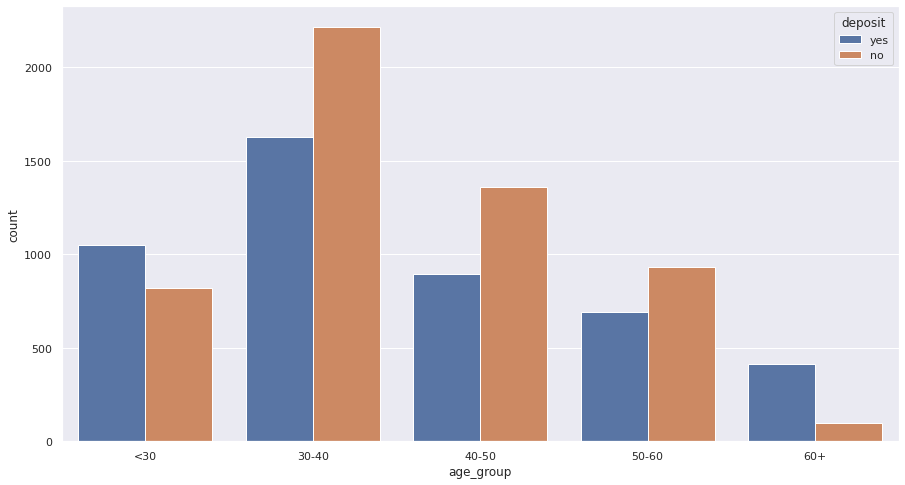

In [183]:
cleaned_df['age_group'] = pd.cut(cleaned_df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=cleaned_df)

### Из пердставленной визуализации видно, что люди до 30 и старше 60 более склонны к открытрию депозита

### Задания 9 и 10

In [184]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = px.sunburst(
cleaned_df, 
path=['marital', 'deposit'],
width=750,
height=550,
title='Влияние признака семейного положения на вероятность открытия депозита',

)
fig.update_traces(textinfo="label+percent entry")
fig.show()

### Из полученной визуализации видно, что люди вне брака вероятнее открывают депозит 

In [185]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = px.sunburst(
cleaned_df, 
path=['education', 'deposit'],
width=750,
height=550,
title='Влияние признака образования на вероятность открытия депозита',

)
fig.update_traces(textinfo="label+percent entry")
fig.show()

### Люди с двумя образованиями меньше открывают депозит

In [186]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = px.sunburst(
cleaned_df, 
path=['job', 'deposit'],
width=750,
height=550,
title='Влияние признака cсферы занятости на вероятность открытия депозита',

)
fig.update_traces(textinfo="label+percent entry")
fig.show()

### Сфера занятости почти не влияет на вероятность октырия депозита, за исключением голубых воротничков, процент открывших в два раза меньше

### Задание 11

Text(111.5, 0.5, 'Образование')

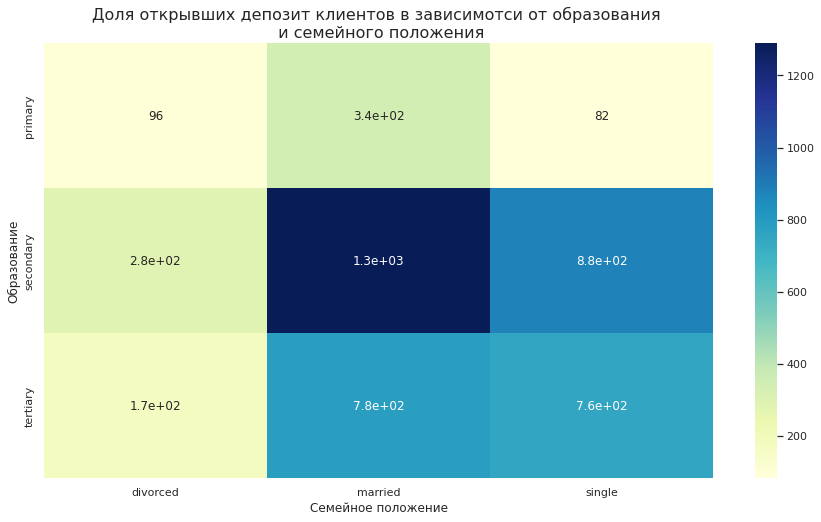

In [187]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
dep_true_df = cleaned_df[cleaned_df['deposit'] == 'yes']
pivot_true_df = dep_true_df.pivot_table(values='deposit', index = 'education', columns = 'marital', aggfunc = 'count') 
sns.set(rc = {'figure.figsize':(15,8)})
heatmap = sns.heatmap(data=pivot_true_df, cmap='YlGnBu', annot=True, fmt='.2g')
heatmap.set_title('Доля открывших депозит клиентов в зависимотси от образования \n и семейного положения', fontsize=16);
heatmap.set_xlabel('Семейное положение')
heatmap.set_ylabel('Образование')

Text(111.5, 0.5, 'Образование')

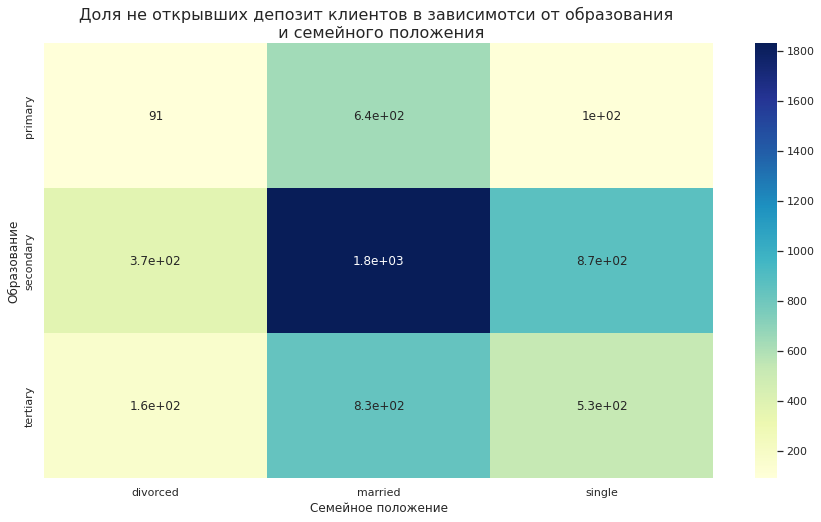

In [188]:
dep_false_df = cleaned_df[cleaned_df['deposit'] == 'no']
pivot_false_df = dep_false_df.pivot_table(values='deposit', index = 'education', columns = 'marital', aggfunc = 'count') 
sns.set(rc = {'figure.figsize':(15,8)})
heatmap = sns.heatmap(data=pivot_false_df, cmap='YlGnBu', annot=True, fmt='.2g')
heatmap.set_title('Доля не открывших депозит клиентов в зависимотси от образования \n и семейного положения', fontsize=16);
heatmap.set_xlabel('Семейное положение')
heatmap.set_ylabel('Образование')

## Часть 3: преобразование данных

### Задание 1

In [189]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
type_bin = labelencoder.fit_transform(cleaned_df['education'])
type_bin = pd.DataFrame(type_bin)
type_bin.columns = ['education']
cleaned_df=cleaned_df.drop(columns = 'education')
data_edu_encoded = pd.concat([cleaned_df, type_bin], axis = 1)
data_edu_encoded['education'].sum()


11995

In [190]:
data_edu_encoded

,age,job,marital,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group,education
0,59,admin.,married,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60,1
1,56,admin.,married,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60,1
2,41,technician,married,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50,1
3,55,services,married,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60,1
4,54,admin.,married,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,33,blue-collar,single,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30-40,0
10101,39,services,married,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30-40,1
10102,32,technician,single,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30-40,1
10103,43,technician,married,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,40-50,1


In [191]:
# преобразование возраста
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
type_bin = labelencoder.fit_transform(cleaned_df['age_group'])
type_bin = pd.DataFrame(type_bin)
data_edu_encoded=data_edu_encoded.drop(columns = 'age_group')
type_bin.columns = ['age_group']
data_ag_encoded = pd.concat([data_edu_encoded, type_bin], axis = 1)


### Задания 2 и 3

In [192]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# преобразование целевой переменной deposit
data_ag_encoded['deposit'] = data_ag_encoded['deposit'].apply(lambda x: 1 if x == 'yes' else 0) 
 

In [193]:
data_ag_encoded['deposit'].std()

0.4986712532452124

In [194]:
data_ag_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   default    10105 non-null  object 
 4   balance    10105 non-null  float64
 5   housing    10105 non-null  object 
 6   loan       10105 non-null  object 
 7   contact    10105 non-null  object 
 8   day        10105 non-null  int64  
 9   month      10105 non-null  object 
 10  duration   10105 non-null  int64  
 11  campaign   10105 non-null  int64  
 12  pdays      10105 non-null  int64  
 13  previous   10105 non-null  int64  
 14  poutcome   10105 non-null  object 
 15  deposit    10105 non-null  int64  
 16  education  10105 non-null  int64  
 17  age_group  10105 non-null  int64  
dtypes: float64(1), int64(9), object(8)
memory usage: 1.4+ MB


In [195]:
# преобразование остальных бинарных признаков
data_ag_encoded['default'] = data_ag_encoded['default'].apply(lambda x: 1 if x == 'yes' else 0) 
data_ag_encoded['housing'] = data_ag_encoded['housing'].apply(lambda x: 1 if x == 'yes' else 0) 
data_ag_encoded['loan'] = data_ag_encoded['loan'].apply(lambda x: 1 if x == 'yes' else 0) 

In [196]:
data_ag_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   default    10105 non-null  int64  
 4   balance    10105 non-null  float64
 5   housing    10105 non-null  int64  
 6   loan       10105 non-null  int64  
 7   contact    10105 non-null  object 
 8   day        10105 non-null  int64  
 9   month      10105 non-null  object 
 10  duration   10105 non-null  int64  
 11  campaign   10105 non-null  int64  
 12  pdays      10105 non-null  int64  
 13  previous   10105 non-null  int64  
 14  poutcome   10105 non-null  object 
 15  deposit    10105 non-null  int64  
 16  education  10105 non-null  int64  
 17  age_group  10105 non-null  int64  
dtypes: float64(1), int64(12), object(5)
memory usage: 1.4+ MB


In [197]:
data_ag_encoded['default'].mean()+data_ag_encoded['housing'].mean()+data_ag_encoded['loan'].mean()

0.6354280059376547

### Задание 4

In [198]:
# создайте дамми-переменные
data_dummies = pd.get_dummies(data_ag_encoded, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

In [199]:
data_dummies.shape

(10105, 46)

### Задания 5 и 6

In [200]:
cor_M = data_dummies.corr()
cor_M['deposit']
cor_m_d = pd.DataFrame(cor_M['deposit'],)
cor_m_d.reset_index(inplace=True)
cor_m_d.columns = ['sign', 'cor_value']


<AxesSubplot:>

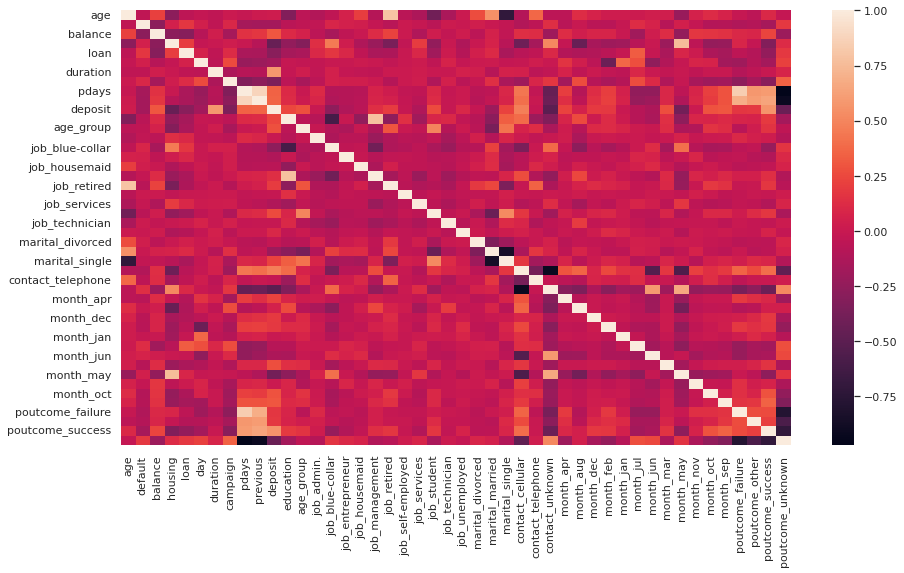

In [201]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
import seaborn as sns # импортируем seaborn для построения графиков
sns.heatmap(cor_M.corr()) # включаем отображение коэффициентов

In [202]:

cor_m_d = cor_m_d.sort_values(by='cor_value', ascending=False)
cor_m_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 10 to 29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sign       46 non-null     object 
 1   cor_value  46 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


<AxesSubplot:xlabel='cor_value', ylabel='sign'>

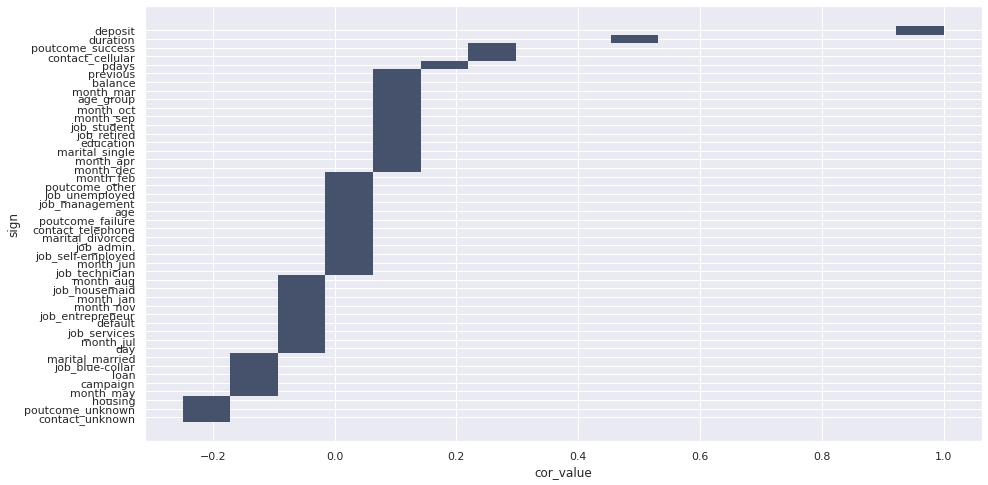

In [203]:
sns.histplot(cor_m_d, y='sign', x="cor_value")

### Задания 7 и 8

In [204]:
X = data_dummies.drop(['deposit'], axis=1)
y = data_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [205]:
X_test.shape

(3335, 45)

In [206]:
y_test.mean()# рассчитайте необходимые показатели

0.46326836581709147

In [207]:
X_test['age_group']

2933    3
5397    2
5043    0
2295    0
8102    2
       ..
1552    4
8743    0
7737    0
9930    4
3371    1
Name: age_group, Length: 3335, dtype: int64

In [208]:
#X_test = X_test.drop(columns = ['education', 'default', 'housing', 'loan'])
#X_train = X_train.drop(columns = ['education', 'default', 'housing', 'loan'])

In [209]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3335 entries, 2933 to 3371
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3335 non-null   int64  
 1   default            3335 non-null   int64  
 2   balance            3335 non-null   float64
 3   housing            3335 non-null   int64  
 4   loan               3335 non-null   int64  
 5   day                3335 non-null   int64  
 6   duration           3335 non-null   int64  
 7   campaign           3335 non-null   int64  
 8   pdays              3335 non-null   int64  
 9   previous           3335 non-null   int64  
 10  education          3335 non-null   int64  
 11  age_group          3335 non-null   int64  
 12  job_admin.         3335 non-null   uint8  
 13  job_blue-collar    3335 non-null   uint8  
 14  job_entrepreneur   3335 non-null   uint8  
 15  job_housemaid      3335 non-null   uint8  
 16  job_management     33

### Задание 9

In [210]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_regression
selector_KBest = SelectKBest(f_classif, k=15)
selector_KBest.fit(X_train, y_train)
KBest = selector_KBest.get_feature_names_out()
print(KBest)

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [211]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train[KBest])
mm_train = mm_scaler.transform(X_train[KBest])
mm_test = mm_scaler.transform(X_test[KBest])
list(X_train[KBest].columns)
df_mm_train = pd.DataFrame(mm_train, columns=list(X_train[KBest].columns))
df_mm_test = pd.DataFrame(mm_test, columns=list(X_test[KBest].columns))
df_mm_test.mean()



balance             0.468237
housing             0.484858
duration            0.093294
campaign            0.036153
pdays               0.062139
previous            0.014501
age_group           0.363868
contact_cellular    0.718741
contact_unknown     0.209295
month_mar           0.023688
month_may           0.251574
month_oct           0.031484
month_sep           0.029385
poutcome_success    0.097451
poutcome_unknown    0.743928
dtype: float64

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [212]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Обучим модель при помощи логистической регресии, гипперпаратметры по умолчанию

#Создаём объект класса LinearRegression
from sklearn.metrics import accuracy_score
log_reg_base_model = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg_base_model.fit(df_mm_train, y_train)
y_test_predict = log_reg_base_model.predict(df_mm_test)


print(metrics.classification_report(y_test, y_test_predict)) 
print(accuracy_score(y_test, y_test_predict, normalize=True))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335

0.8083958020989506


### Задания 2,3,4

In [213]:
# обучите решающие деревья, настройте максимальную глубину
dt_base_model = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt_base_model.fit(df_mm_train, y_train)
y_test_predict = dt_base_model.predict(df_mm_test)
y_train_predict = dt_base_model.predict(df_mm_train)
print(accuracy_score(y_test, y_test_predict, normalize=True))
print(accuracy_score(y_train, y_train_predict, normalize=True))

0.8065967016491754
0.8180206794682422


### Задание 5

In [214]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}
grid_search = GridSearchCV(tree.DecisionTreeClassifier(
        random_state=42, #генератор случайных чисел
    ), 
    param_grid=param_grid, 
    scoring=('f1'),
    cv=3,
    return_train_score=True
    )
grid_search.fit(df_mm_train, y_train) 
print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
y_test_pred = grid_search.predict(df_mm_test)
print('f1_score на тестовом наборе: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
y_train_pred = grid_search.predict(df_mm_train)
print('f1_score на тркенировачном наборе: {:.4f}'.format(metrics.f1_score(y_train, y_train_pred)))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 2}
f1_score на тестовом наборе: 0.8008
f1_score на тркенировачном наборе: 0.8258


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [215]:
# обучите на ваших данных случайный лес
from sklearn.metrics import recall_score
rf_base_model = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
    )
rf_base_model.fit(df_mm_train, y_train)
y_pred = rf_base_model.predict(df_mm_test)
#оценим метрику F1
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_pred)))
print(accuracy_score(y_test, y_pred, normalize=True))
print(recall_score(y_test, y_pred))


f1_score на тестовом наборе: 0.817
0.8266866566716642
0.8330097087378641


### Задания 2 и 3

In [216]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb_model = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

gb_model.fit(df_mm_train, y_train) 
y_test_pred = gb_model.predict(df_mm_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(accuracy_score(y_test, y_test_pred, normalize=True))
print(recall_score(y_test, y_test_pred))



f1_score на тестовом наборе: 0.816
0.8263868065967016
0.8317152103559871


### Задание 4

In [217]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

estimators = [
    ('dt_base_model', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
    )),
    
    ('rf_base_model',  linear_model.LogisticRegression(random_state=42, solver='sag')),
    
    ('gb_model',  ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    ))
]

reg = StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=LogisticRegression(random_state=42)
)

reg.fit(df_mm_train, y_train) 
y_test_pred = reg.predict(df_mm_test)
print(precision_score(y_test, y_test_pred))

0.8099547511312217


### Задание 5

In [218]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
imp_features = gb_model.feature_importances_
df_imp_features = pd.DataFrame(df_mm_train.columns).join(pd.DataFrame({"weights":imp_features}))
df_imp_features.sort_values(by=['weights'], ascending=False)

,0,weights
2,duration,0.507106
13,poutcome_success,0.114958
8,contact_unknown,0.072614
0,balance,0.057952
4,pdays,0.055079
1,housing,0.047725
6,age_group,0.039902
9,month_mar,0.027819
11,month_oct,0.019880
10,month_may,0.015214


### Задания 6,7,8

In [235]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
#Настроим оптимизацию гиперпараметров для алгоритма логистической регресии без кросс-валидации.
def optuna_rfc_f1(trial):
  # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
    max_depth = trial.suggest_int('max_depth', 10, 30, 1);
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf, random_state=42)
  # обучаем модель
    model.fit(df_mm_train, y_train)
    score_f1 = metrics.f1_score(y_test, model.predict(df_mm_test))
    return score_f1
  
  


In [236]:
def optuna_rfc_acc(trial):
  # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
    max_depth = trial.suggest_int('max_depth', 10, 30, 1);
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf, random_state=42)
  # обучаем модель
    model.fit(df_mm_train, y_train)
    score_acc = accuracy_score(y_test, y_test_pred, normalize=True)
    return score_acc
  

In [241]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_f1 = optuna.create_study(study_name="RandomForestClassifier_f1", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_f1.optimize(optuna_rfc_f1, n_trials=20)

[I 2023-04-24 21:17:37,935] A new study created in memory with name: RandomForestClassifier_f1
[I 2023-04-24 21:17:38,642] Trial 0 finished with value: 0.8162878787878789 and parameters: {'n_estimators': 173, 'max_depth': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8162878787878789.
[I 2023-04-24 21:17:39,276] Trial 1 finished with value: 0.8116862496030486 and parameters: {'n_estimators': 154, 'max_depth': 24, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8162878787878789.
[I 2023-04-24 21:17:39,807] Trial 2 finished with value: 0.8133545310015898 and parameters: {'n_estimators': 134, 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8162878787878789.
[I 2023-04-24 21:17:40,655] Trial 3 finished with value: 0.8200125865324104 and parameters: {'n_estimators': 194, 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8200125865324104.
[I 2023-04-24 21:17:41,226] Trial 4 finished with value: 0.8132357620108176 and parameters:

CPU times: user 13.8 s, sys: 27.9 ms, total: 13.8 s
Wall time: 13.8 s


In [242]:
print("Наилучшие значения гиперпараметров {}".format(study_f1.best_params))
print("f1_score на обучающем наборе: {:.5f}".format(study_f1.best_value))


Наилучшие значения гиперпараметров {'n_estimators': 162, 'max_depth': 25, 'min_samples_leaf': 4}
f1_score на обучающем наборе: 0.82150


In [243]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_acc = optuna.create_study(study_name="RandomForestClassifier_acc", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_acc.optimize(optuna_rfc_acc, n_trials=20)

[I 2023-04-24 21:17:57,995] A new study created in memory with name: RandomForestClassifier_acc
[I 2023-04-24 21:17:58,728] Trial 0 finished with value: 0.824287856071964 and parameters: {'n_estimators': 189, 'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.824287856071964.
[I 2023-04-24 21:17:59,248] Trial 1 finished with value: 0.824287856071964 and parameters: {'n_estimators': 139, 'max_depth': 28, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.824287856071964.
[I 2023-04-24 21:17:59,876] Trial 2 finished with value: 0.824287856071964 and parameters: {'n_estimators': 176, 'max_depth': 26, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.824287856071964.
[I 2023-04-24 21:18:00,613] Trial 3 finished with value: 0.824287856071964 and parameters: {'n_estimators': 184, 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.824287856071964.
[I 2023-04-24 21:18:01,287] Trial 4 finished with value: 0.824287856071964 and parameters: {'n_estim

CPU times: user 12.3 s, sys: 11.9 ms, total: 12.3 s
Wall time: 12.3 s


In [244]:
print("Наилучшие значения гиперпараметров {}".format(study_acc.best_params))
print("accuracy_score на обучающем наборе: {:.5f}".format(study_acc.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 189, 'max_depth': 12, 'min_samples_leaf': 6}
accuracy_score на обучающем наборе: 0.82429


## Выводы по поиску лучших алгоритмов
###  Были рассмотерны раздичные варианты алгоритмов: 
### 1. Логистическая регрессия
### 2. Деревья решений
### 3. Был применен подбор гипперпараметров для деревьев решений методом поиска по сетке
### 4. Случайный лес
### 5. Стекинг
### 6. Подбор гипперпаратмеров методом Optuna для Случайного леса.

### Последний метод показал лучший рещультат 

## Выводы по проекту
### Была поставлена задача построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет. 
### Перед построением моделей данными были обработаны, изабились от выбросов и пропусков, проведен разведывательный анализ данных, признаки были преобразованы для обучения и выбраны лучшие из них. Далее были примененф различные методы машинного обучения, качество которых оценивалось метриками. В результате было выяснено, что лучше всего для орпеделения откроет клиент депозит или нет подходит метод случайного леса, гипперпапраметры которого были подобарнны методом Optuna.